In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [118]:
csv_files = glob.glob("data/raw/heart_rates/*.csv")
csv_files = [csv_file.replace("\\", "/") for csv_file in csv_files]

In [22]:
all_data = pd.concat(
    (pd.read_csv(file).assign(date=file.split('/')[-1].replace('.csv', '')) for file in csv_files),
    ignore_index=True
)

In [23]:
all_data.head()

,timestamp,heart_rates,date
0,14:58,69.0,2024-12-21
1,15:00,70.0,2024-12-21
2,15:02,66.0,2024-12-21
3,15:04,71.0,2024-12-21
4,15:06,75.0,2024-12-21


In [24]:
all_data.tail()

,timestamp,heart_rates,date
8163,07:58,74.0,2025-01-02
8164,08:00,62.0,2025-01-02
8165,08:02,63.0,2025-01-02
8166,08:04,67.0,2025-01-02
8167,08:06,61.0,2025-01-02


In [25]:
all_data.dtypes

timestamp       object
heart_rates    float64
date            object
dtype: object

In [116]:
missing_values_counts = all_data.isna().sum()
missing_values_counts

timestamp       0
heart_rates    23
date            0
dtype: int64

In [142]:
def standardize_dataframe(df, timestamp_column):
    df[timestamp_column] = pd.to_datetime(df[timestamp_column], format="%H:%M").dt.time

    expected_items = pd.date_range(start="00:00", end="23:58", freq="2min").time
    
    df.set_index(timestamp_column, inplace=True)
    df = df.reindex(expected_items)
    
    df.index.name = 'timestamp'
    
    return df


In [143]:
nan_counts = {}

for file_name in csv_files:
    day = file_name.split("/")[-1].replace(".csv", "")
    df = pd.read_csv(file_name)

    df = standardize_dataframe(df, timestamp_column="timestamp")

    nan_count = int(df['heart_rates'].isna().sum())
    nan_counts[day] = nan_count
    
    print(f"{day}: {nan_count} NaN values")

2024-12-21: 490 NaN values
2024-12-22: 2 NaN values
2024-12-23: 0 NaN values
2024-12-24: 0 NaN values
2024-12-25: 138 NaN values
2024-12-26: 0 NaN values
2024-12-27: 72 NaN values
2024-12-28: 17 NaN values
2024-12-29: 0 NaN values
2024-12-30: 0 NaN values
2024-12-31: 0 NaN values
2025-01-01: 20 NaN values
2025-01-02: 476 NaN values


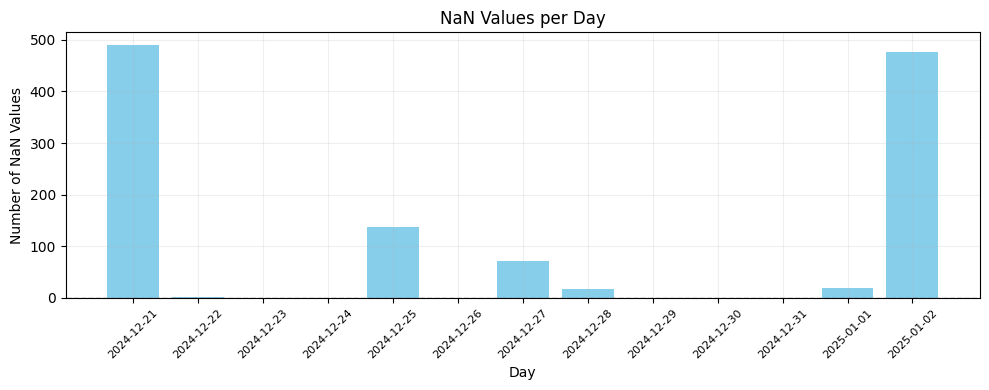

In [144]:
nan_df = pd.DataFrame(list(nan_counts.items()), columns=["Day", "NaN_Count"])

plt.figure(figsize=(10,4))
plt.bar(nan_df["Day"], nan_df["NaN_Count"], color='skyblue')

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Day")
plt.ylabel("Number of NaN Values")
plt.title("NaN Values per Day")
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

In [145]:
print(nan_counts)

{'2024-12-21': 490, '2024-12-22': 2, '2024-12-23': 0, '2024-12-24': 0, '2024-12-25': 138, '2024-12-26': 0, '2024-12-27': 72, '2024-12-28': 17, '2024-12-29': 0, '2024-12-30': 0, '2024-12-31': 0, '2025-01-01': 20, '2025-01-02': 476}


In [146]:
threshold = 700

for day, value in nan_counts.items():
    valid_count = 720 - value

    if valid_count >= threshold:
        print(f"Processing day: {day} (Valid rows: {valid_count})")

        df = pd.read_csv(f"data/raw/heart_rates/{day}.csv")
        df = standardize_dataframe(df, timestamp_column="timestamp")
        
        df['heart_rates'] = df['heart_rates'].interpolate(method='linear', limit_direction='both')

        df.to_csv(f"data/processed/heart_rates/{day}_completed.csv")
        print(f"Completed interpolation for {day}")

Processing day: 2024-12-22 (Valid rows: 718)
Completed interpolation for 2024-12-22
Processing day: 2024-12-23 (Valid rows: 720)
Completed interpolation for 2024-12-23
Processing day: 2024-12-24 (Valid rows: 720)
Completed interpolation for 2024-12-24
Processing day: 2024-12-26 (Valid rows: 720)
Completed interpolation for 2024-12-26
Processing day: 2024-12-28 (Valid rows: 703)
Completed interpolation for 2024-12-28
Processing day: 2024-12-29 (Valid rows: 720)
Completed interpolation for 2024-12-29
Processing day: 2024-12-30 (Valid rows: 720)
Completed interpolation for 2024-12-30
Processing day: 2024-12-31 (Valid rows: 720)
Completed interpolation for 2024-12-31
Processing day: 2025-01-01 (Valid rows: 700)
Completed interpolation for 2025-01-01
